In [1]:
!rm -rf /kaggle/working/*


=== Federated Round 1 ===
Client 1 | Loss: 0.5675 | Acc: 0.7808
Client 2 | Loss: 0.5597 | Acc: 0.7831
Client 3 | Loss: 0.5694 | Acc: 0.7810
Client 4 | Loss: 0.5609 | Acc: 0.7822
Client 5 | Loss: 0.5728 | Acc: 0.7810

=== Federated Round 2 ===
Client 1 | Loss: 0.2916 | Acc: 0.8809
Client 2 | Loss: 0.2915 | Acc: 0.8804
Client 3 | Loss: 0.2937 | Acc: 0.8804
Client 4 | Loss: 0.2861 | Acc: 0.8822
Client 5 | Loss: 0.2921 | Acc: 0.8802

=== Federated Round 3 ===
Client 1 | Loss: 0.2618 | Acc: 0.8912
Client 2 | Loss: 0.2624 | Acc: 0.8917
Client 3 | Loss: 0.2627 | Acc: 0.8914
Client 4 | Loss: 0.2620 | Acc: 0.8905
Client 5 | Loss: 0.2605 | Acc: 0.8919

=== Federated Round 4 ===
Client 1 | Loss: 0.2490 | Acc: 0.8971
Client 2 | Loss: 0.2519 | Acc: 0.8956
Client 3 | Loss: 0.2490 | Acc: 0.8969
Client 4 | Loss: 0.2483 | Acc: 0.8963
Client 5 | Loss: 0.2501 | Acc: 0.8957

=== Federated Round 5 ===
Client 1 | Loss: 0.2416 | Acc: 0.8999
Client 2 | Loss: 0.2429 | Acc: 0.8990
Client 3 | Loss: 0.2396 | Acc

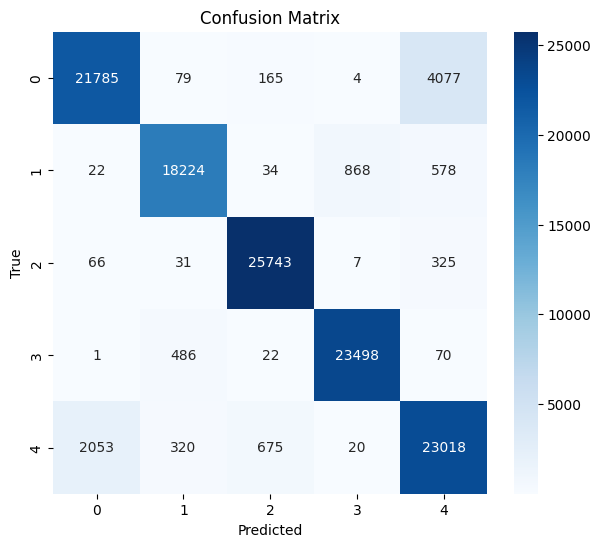

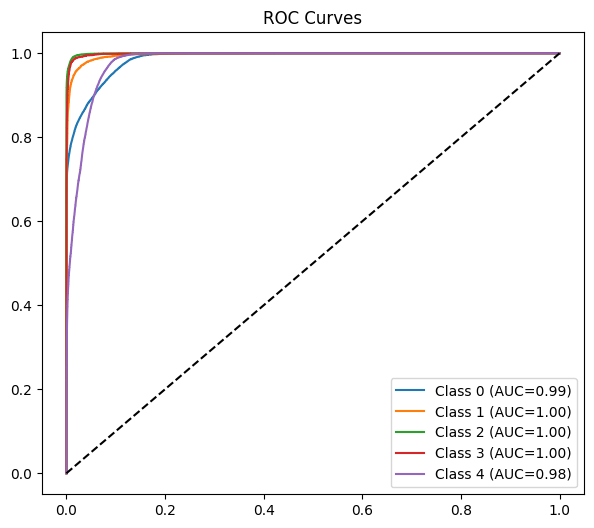


All results saved to: /kaggle/working/federated_results


In [2]:
# ============================================================
# Federated GCN for UAV Intrusion Detection
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION (SPARSE)
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)

A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS (FEDERATED)
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    return model.state_dict(), np.mean(losses), accuracy_score(labels_all, preds_all)

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Federated Round {rnd} ===")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# PER-CLIENT PER-ATTACK METRICS
# ---------------------------
global_model.eval()

for cid in range(NUM_CLIENTS):
    edges = client_splits[cid]
    src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
    dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)

    with torch.no_grad():
        out = global_model.forward_edges(X, A_sparse, src, dst)

    preds = out.argmax(1).cpu().numpy()
    true = edge_labels[edges]

    p, r, f, _ = precision_recall_fscore_support(true, preds, average=None, zero_division=0)

    df_metrics = pd.DataFrame({
        "Precision": p,
        "Recall": r,
        "F1-Score": f
    })

    df_metrics.to_csv(f"{OUTPUT_DIR}/client_{cid+1}_per_attack_metrics.csv",
                      index_label="Attack_Class")

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
test_loader = edge_loader(test_edges, shuffle=False)

all_preds, all_true, all_probs = [], [], []

with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png")
plt.show()

print("\nAll results saved to:", OUTPUT_DIR)


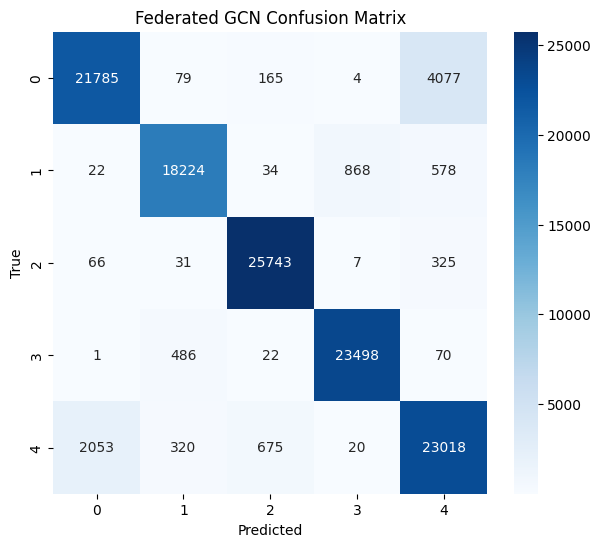

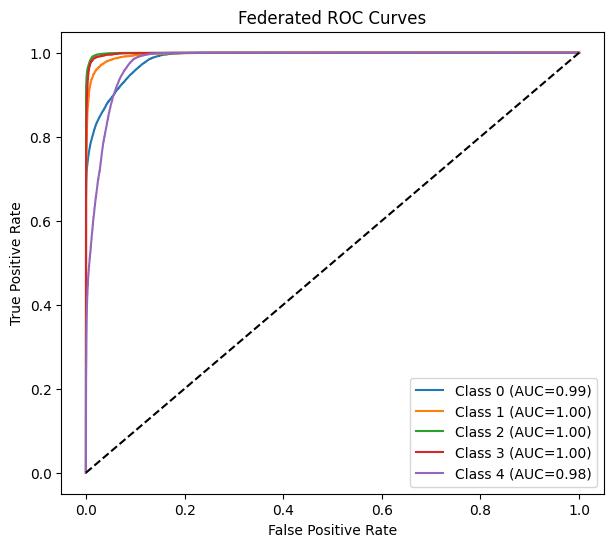

✅ All results saved as BOTH .png and .mat in:
/kaggle/working/federated_results


In [3]:
# ============================================================
# RESULTS EXPORT CELL (PNG + MAT)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ---------------------------
# 1. CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)

# Save .mat
savemat(
    f"{OUTPUT_DIR}/confusion_matrix.mat",
    {
        "confusion_matrix": cm,
        "class_labels": np.arange(NUM_CLASSES)
    }
)

# Save .png
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Federated GCN Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 2. ROC CURVES (PER CLASS)
# ---------------------------
y_bin = label_binarize(all_true, classes=np.arange(NUM_CLASSES))

roc_data = {}

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    roc_data[f"class_{i}"] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    }

    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Federated ROC Curves")
plt.legend()
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# Save ROC to .mat
savemat(
    f"{OUTPUT_DIR}/roc_curves.mat",
    roc_data
)

# ---------------------------
# 3. PER-CLIENT PER-ATTACK METRICS
# ---------------------------
# Assumes client CSVs already created earlier
# Convert them to .mat for MATLAB use

import glob
import pandas as pd

client_metric_files = glob.glob(f"{OUTPUT_DIR}/client_*_per_attack_metrics.csv")

client_metrics_mat = {}

for file in client_metric_files:
    client_id = os.path.basename(file).replace("_per_attack_metrics.csv","")
    df = pd.read_csv(file)
    client_metrics_mat[client_id] = df.values

savemat(
    f"{OUTPUT_DIR}/client_per_attack_metrics.mat",
    client_metrics_mat
)

# ---------------------------
# 4. GLOBAL SUMMARY METRICS
# ---------------------------
overall_accuracy = np.mean(np.array(all_true) == np.array(all_preds))

savemat(
    f"{OUTPUT_DIR}/global_summary.mat",
    {
        "overall_accuracy": overall_accuracy,
        "num_classes": NUM_CLASSES,
        "num_samples": len(all_true)
    }
)

print("✅ All results saved as BOTH .png and .mat in:")
print(OUTPUT_DIR)


**===============This section is after the comments of Dr Sohail Abbas======================**

**FL-GCN=============================================================================**


=== Federated Round 1 ===
Client 1 | Loss: 0.5801 | Acc: 0.7787
Client 2 | Loss: 0.5829 | Acc: 0.7773
Client 3 | Loss: 0.5800 | Acc: 0.7777
Client 4 | Loss: 0.5788 | Acc: 0.7782
Client 5 | Loss: 0.5797 | Acc: 0.7787

=== Federated Round 2 ===
Client 1 | Loss: 0.3151 | Acc: 0.8735
Client 2 | Loss: 0.3084 | Acc: 0.8749
Client 3 | Loss: 0.3114 | Acc: 0.8748
Client 4 | Loss: 0.3098 | Acc: 0.8734
Client 5 | Loss: 0.3176 | Acc: 0.8716

=== Federated Round 3 ===
Client 1 | Loss: 0.2767 | Acc: 0.8893
Client 2 | Loss: 0.2767 | Acc: 0.8889
Client 3 | Loss: 0.2775 | Acc: 0.8890
Client 4 | Loss: 0.2721 | Acc: 0.8895
Client 5 | Loss: 0.2752 | Acc: 0.8901

=== Federated Round 4 ===
Client 1 | Loss: 0.2601 | Acc: 0.8942
Client 2 | Loss: 0.2593 | Acc: 0.8945
Client 3 | Loss: 0.2581 | Acc: 0.8962
Client 4 | Loss: 0.2551 | Acc: 0.8974
Client 5 | Loss: 0.2593 | Acc: 0.8948

=== Federated Round 5 ===
Client 1 | Loss: 0.2454 | Acc: 0.8994
Client 2 | Loss: 0.2477 | Acc: 0.8983
Client 3 | Loss: 0.2479 | Acc

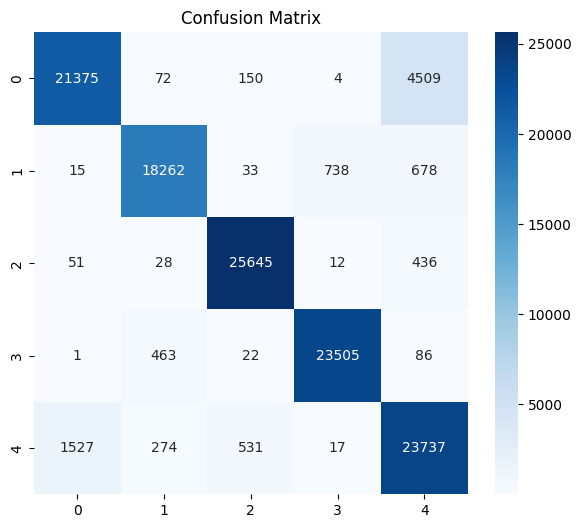

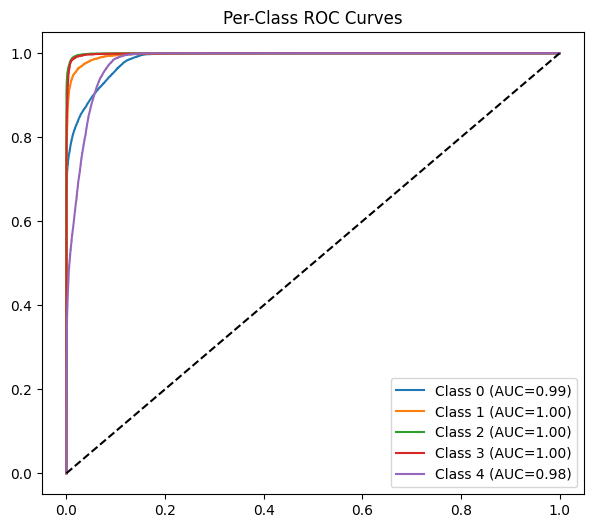


All results saved to: /kaggle/working/federated_results_GCN_FedAvg

=== Client 1 Evaluation ===
Accuracy: 0.9219
Macro F1: 0.9236
Weighted F1: 0.9221
MCC: 0.9030
Kappa: 0.9020


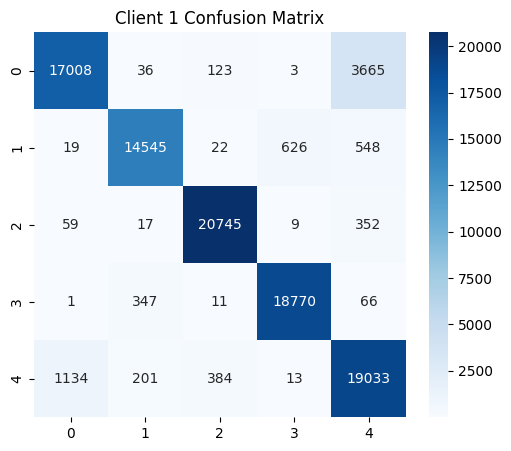

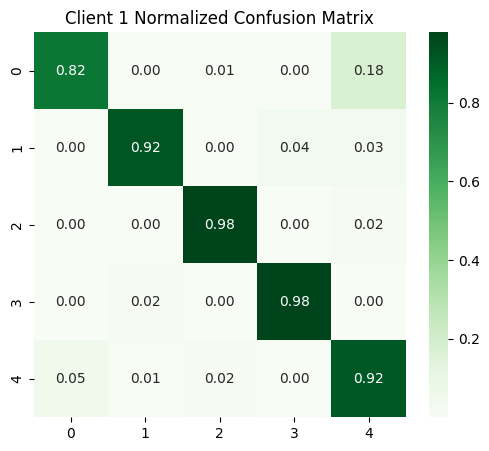

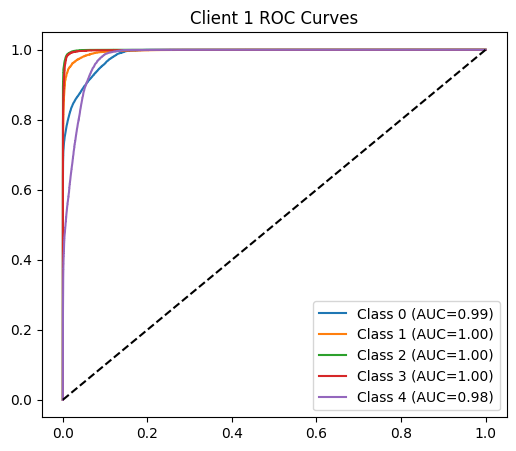


=== Client 2 Evaluation ===
Accuracy: 0.9220
Macro F1: 0.9239
Weighted F1: 0.9223
MCC: 0.9032
Kappa: 0.9023


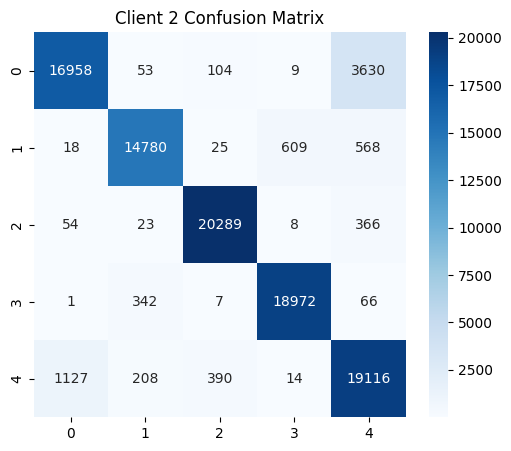

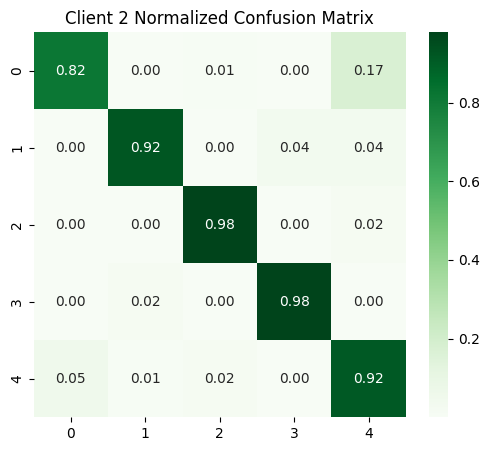

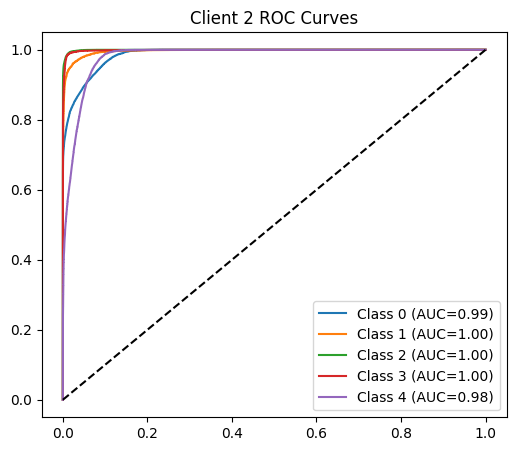


=== Client 3 Evaluation ===
Accuracy: 0.9220
Macro F1: 0.9241
Weighted F1: 0.9222
MCC: 0.9030
Kappa: 0.9022


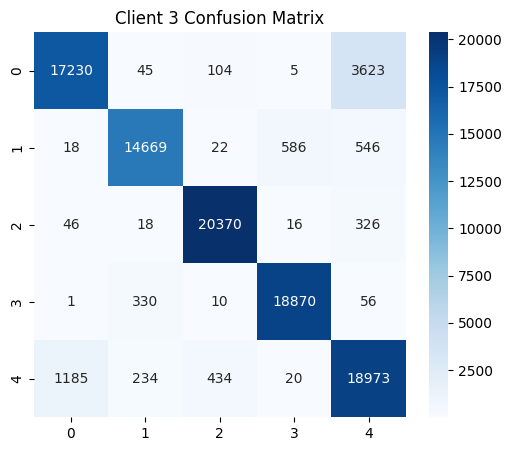

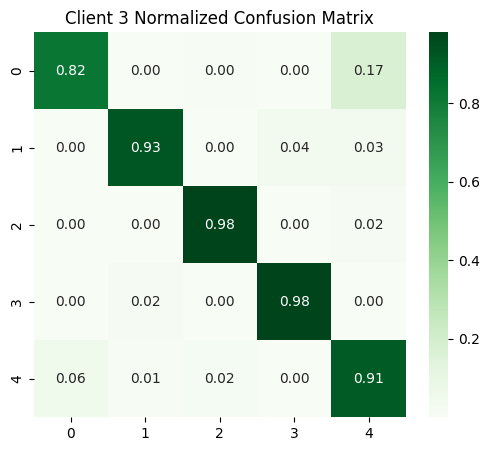

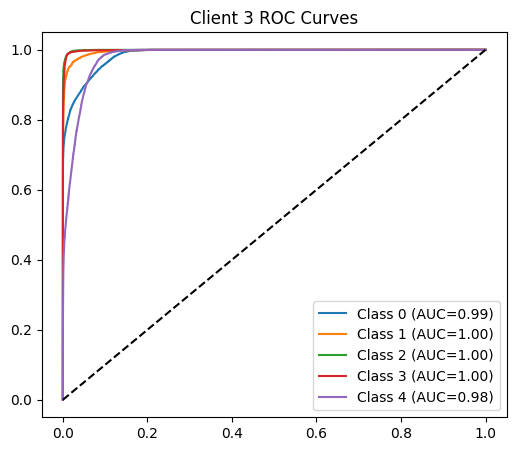


=== Client 4 Evaluation ===
Accuracy: 0.9226
Macro F1: 0.9245
Weighted F1: 0.9229
MCC: 0.9039
Kappa: 0.9030


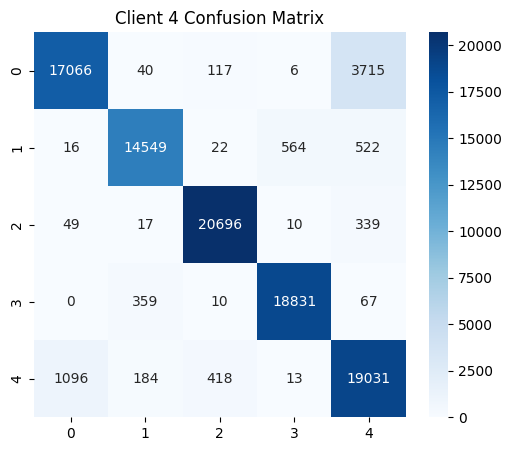

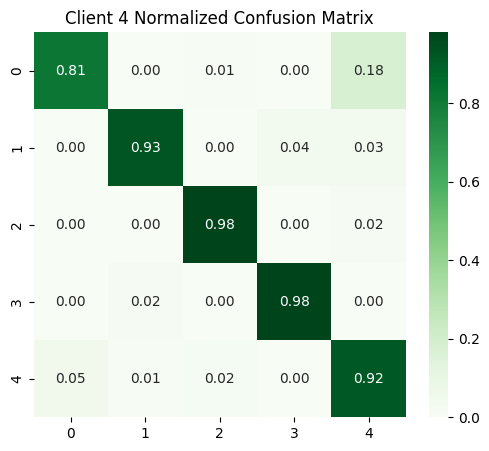

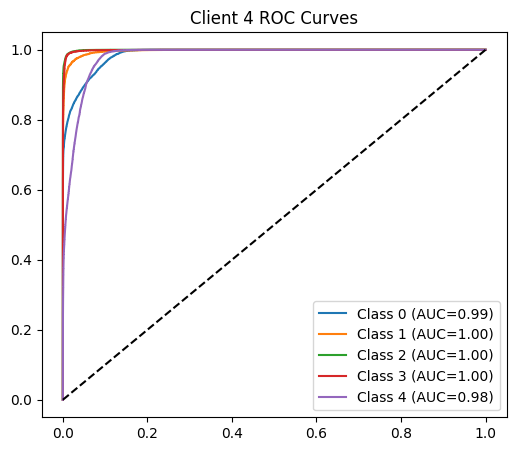


=== Client 5 Evaluation ===
Accuracy: 0.9216
Macro F1: 0.9239
Weighted F1: 0.9218
MCC: 0.9025
Kappa: 0.9017


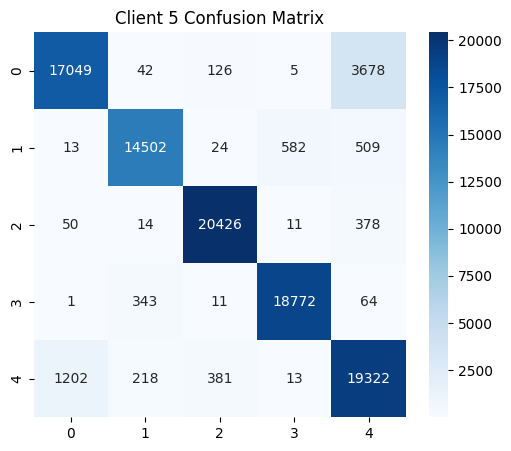

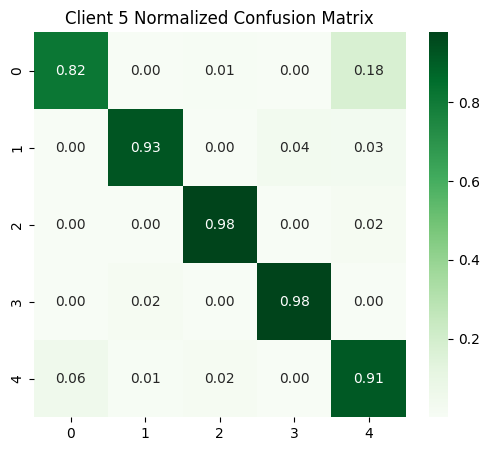

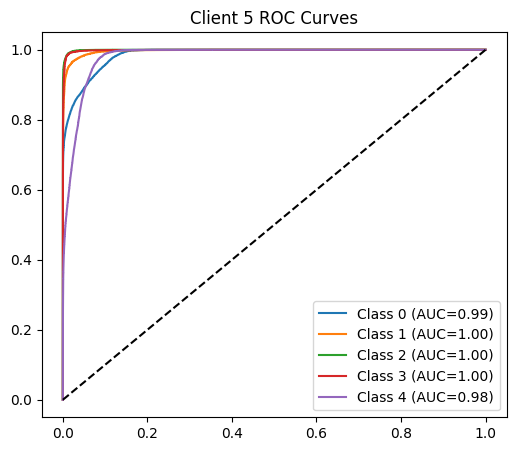


Client-wise metrics saved to: /kaggle/working/federated_results_GCN_FedAvg


In [4]:
# ============================================================
# Federated GCN for UAV Intrusion Detection 
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results_GCN_FedAvg"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS (FEDERATED)
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    return model.state_dict(), np.mean(losses), acc

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Federated Round {rnd} ===")
    local_states = []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        loader = edge_loader(client_splits[cid])
        state, loss, acc = local_train(local_model, loader)
        local_states.append(state)
        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
test_loader = edge_loader(test_edges, shuffle=False)

all_preds, all_true, all_probs = [], [], []

global_model.eval()
with torch.no_grad():
    for src, dst, lbl in test_loader:
        out = global_model.forward_edges(X, A_sparse, src.to(DEVICE), dst.to(DEVICE))
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_true.extend(lbl.numpy())
        all_probs.extend(torch.softmax(out, 1).cpu().numpy())

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(all_true, all_preds)

prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    all_true, all_preds, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_true, all_preds, average="weighted", zero_division=0
)

mcc = matthews_corrcoef(all_true, all_preds)
kappa = cohen_kappa_score(all_true, all_preds)

print("\n=== Global Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"Weighted F1: {f1_w:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

# Save classification report
report = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
pd.DataFrame(report).transpose().to_csv(
    f"{OUTPUT_DIR}/global_classification_report.csv"
)

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()


# ---------------------------
# FPR & FNR
# ---------------------------
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

df_error = pd.DataFrame({
    "FPR": FP / (FP + TN + 1e-8),
    "FNR": FN / (FN + TP + 1e-8)
})
df_error.to_csv(f"{OUTPUT_DIR}/false_rates_per_class.csv")

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("Per-Class ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_per_class.png")
plt.show()

print("\nAll results saved to:", OUTPUT_DIR)




# ============================================================
# CLIENT-WISE PERFORMANCE METRICS
# ============================================================

client_summary = []

for cid in range(NUM_CLIENTS):
    print(f"\n=== Client {cid+1} Evaluation ===")

    edges = client_splits[cid]
    src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
    dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)
    true = edge_labels[edges]

    with torch.no_grad():
        out = global_model.forward_edges(X, A_sparse, src, dst)
        preds = out.argmax(1).cpu().numpy()
        probs = torch.softmax(out, 1).cpu().numpy()

    # ---- Metrics ----
    acc = accuracy_score(true, preds)

    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        true, preds, average="macro", zero_division=0
    )
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        true, preds, average="weighted", zero_division=0
    )

    mcc = matthews_corrcoef(true, preds)
    kappa = cohen_kappa_score(true, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_m:.4f}")
    print(f"Weighted F1: {f1_w:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Kappa: {kappa:.4f}")

    # ---- Save summary ----
    client_summary.append([
        cid + 1, acc, prec_m, rec_m, f1_m, prec_w, rec_w, f1_w, mcc, kappa
    ])

    # ---- Classification report ----
    report = classification_report(true, preds, output_dict=True, zero_division=0)
    pd.DataFrame(report).transpose().to_csv(
        f"{OUTPUT_DIR}/client_{cid+1}_classification_report.csv"
    )

    # ---- Confusion Matrix ----
    cm = confusion_matrix(true, preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Client {cid+1} Confusion Matrix")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_confusion_matrix.png")
    plt.show()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
    plt.title(f"Client {cid+1} Normalized Confusion Matrix")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_confusion_matrix_norm.png")
    plt.show()

    # ---- ROC Curves (Client-wise) ----
    y_bin = label_binarize(true, classes=range(NUM_CLASSES))

    plt.figure(figsize=(6,5))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title(f"Client {cid+1} ROC Curves")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_roc.png")
    plt.show()

# ---------------------------
# SAVE CLIENT SUMMARY TABLE
# ---------------------------
df_clients = pd.DataFrame(
    client_summary,
    columns=[
        "Client", "Accuracy",
        "Macro Precision", "Macro Recall", "Macro F1",
        "Weighted Precision", "Weighted Recall", "Weighted F1",
        "MCC", "Kappa"
    ]
)

df_clients.to_csv(f"{OUTPUT_DIR}/client_wise_summary_metrics.csv", index=False)

print("\nClient-wise metrics saved to:", OUTPUT_DIR)


**Fedfox===========================================================================**


=== Round 1 ===
Client 1 | Loss: 0.6142 | Acc: 0.7726
Client 2 | Loss: 0.6181 | Acc: 0.7733
Client 3 | Loss: 0.6174 | Acc: 0.7718
Client 4 | Loss: 0.6187 | Acc: 0.7724
Client 5 | Loss: 0.6248 | Acc: 0.7708
Round Avg | Loss: 0.6187 | Acc: 0.7722

=== Round 2 ===
Client 1 | Loss: 0.3049 | Acc: 0.8793
Client 2 | Loss: 0.3042 | Acc: 0.8799
Client 3 | Loss: 0.3074 | Acc: 0.8776
Client 4 | Loss: 0.3038 | Acc: 0.8797
Client 5 | Loss: 0.3077 | Acc: 0.8778
Round Avg | Loss: 0.3056 | Acc: 0.8789

=== Round 3 ===
Client 1 | Loss: 0.2704 | Acc: 0.8918
Client 2 | Loss: 0.2719 | Acc: 0.8904
Client 3 | Loss: 0.2694 | Acc: 0.8924
Client 4 | Loss: 0.2659 | Acc: 0.8930
Client 5 | Loss: 0.2713 | Acc: 0.8905
Round Avg | Loss: 0.2698 | Acc: 0.8916

=== Round 4 ===
Client 1 | Loss: 0.2569 | Acc: 0.8955
Client 2 | Loss: 0.2552 | Acc: 0.8963
Client 3 | Loss: 0.2543 | Acc: 0.8972
Client 4 | Loss: 0.2526 | Acc: 0.8981
Client 5 | Loss: 0.2584 | Acc: 0.8950
Round Avg | Loss: 0.2555 | Acc: 0.8964

=== Round 5 ===

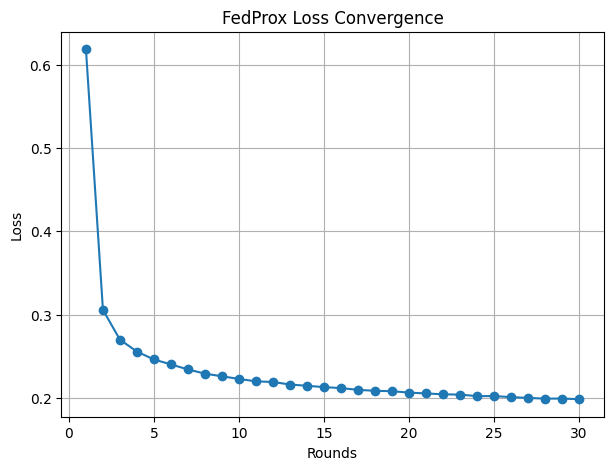

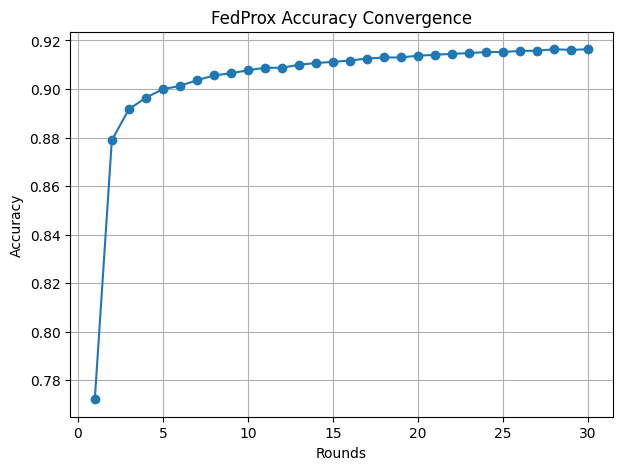


FedProx training complete. Results saved to: /kaggle/working/federated_results_GCN_fedfrox

=== Client 1 Evaluation ===
Accuracy: 0.9210
Macro F1: 0.9226
Weighted F1: 0.9212
MCC: 0.9014
Kappa: 0.9009


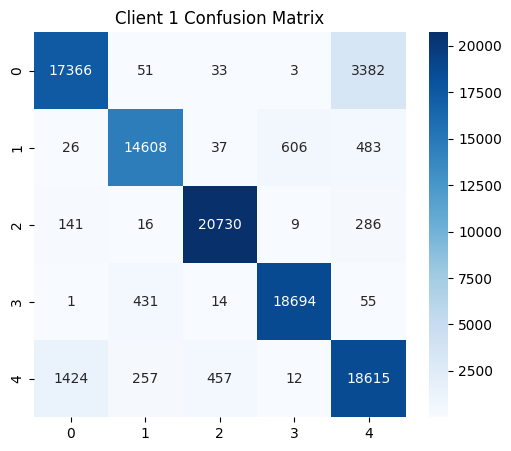

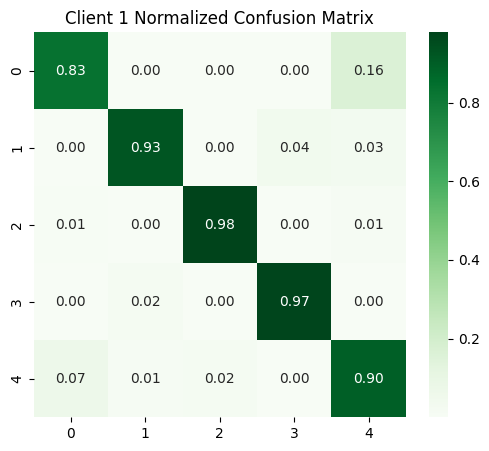

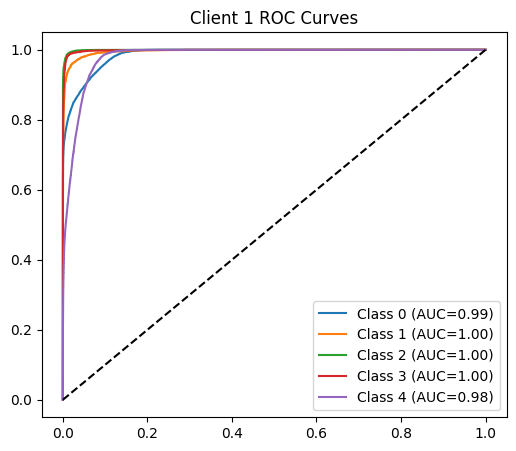


=== Client 2 Evaluation ===
Accuracy: 0.9210
Macro F1: 0.9227
Weighted F1: 0.9212
MCC: 0.9014
Kappa: 0.9009


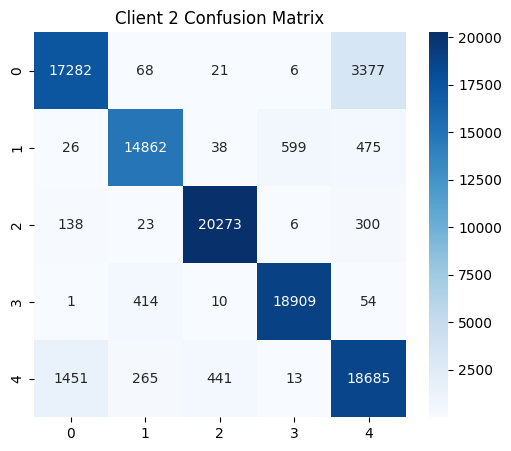

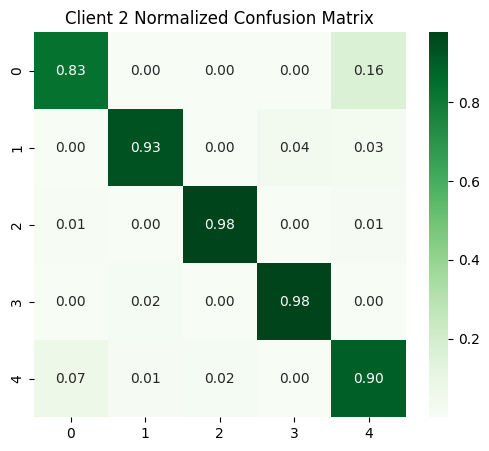

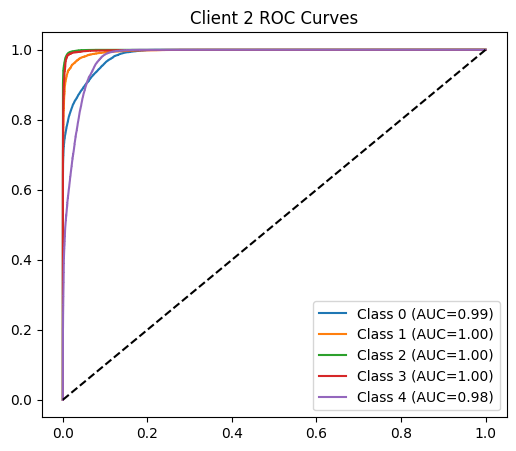


=== Client 3 Evaluation ===
Accuracy: 0.9201
Macro F1: 0.9221
Weighted F1: 0.9203
MCC: 0.9003
Kappa: 0.8999


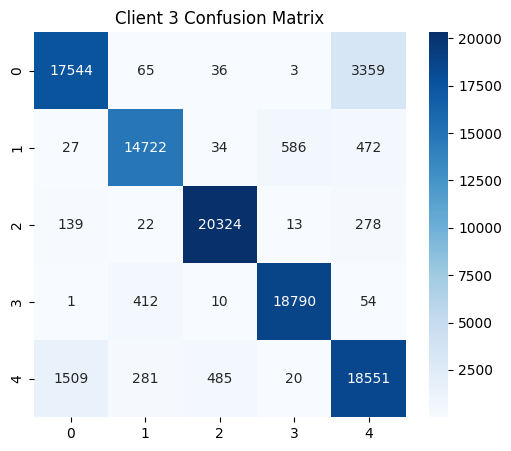

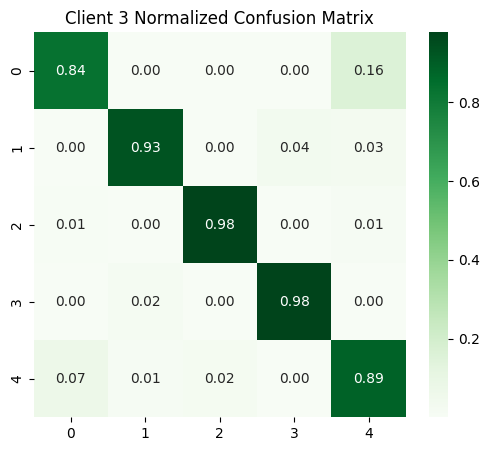

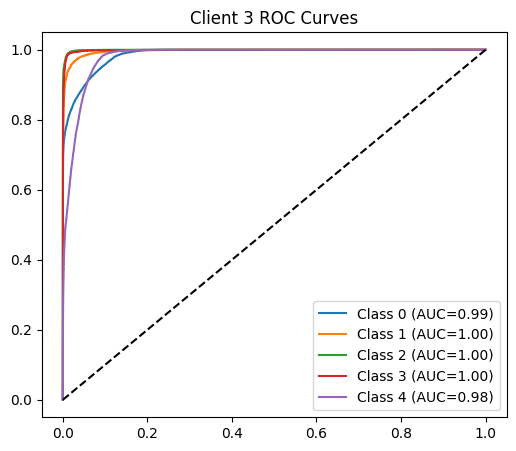


=== Client 4 Evaluation ===
Accuracy: 0.9211
Macro F1: 0.9229
Weighted F1: 0.9213
MCC: 0.9016
Kappa: 0.9011


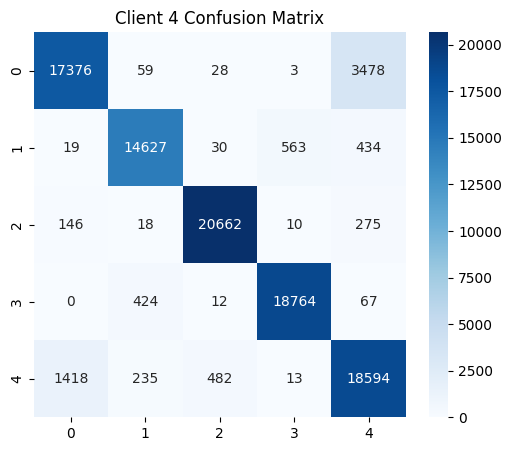

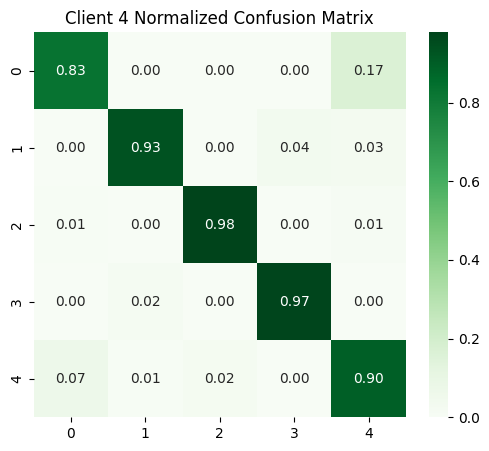

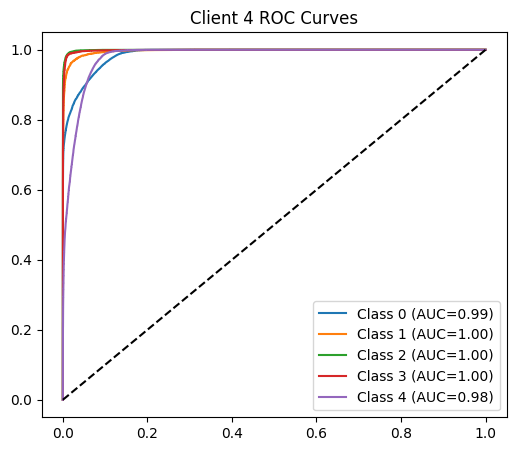


=== Client 5 Evaluation ===
Accuracy: 0.9208
Macro F1: 0.9230
Weighted F1: 0.9210
MCC: 0.9011
Kappa: 0.9007


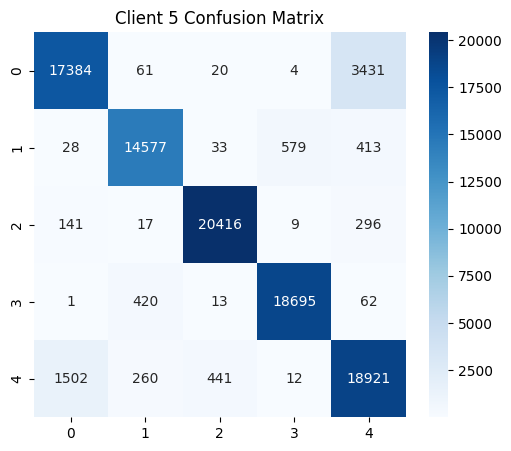

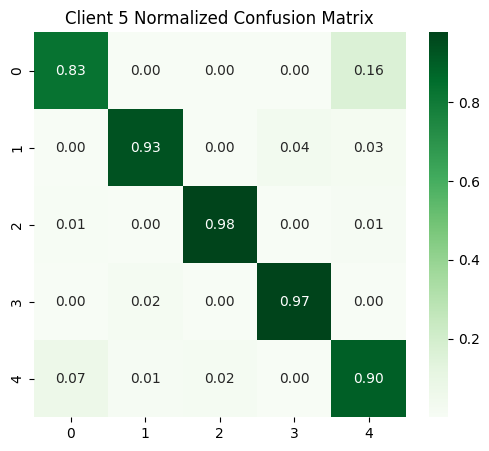

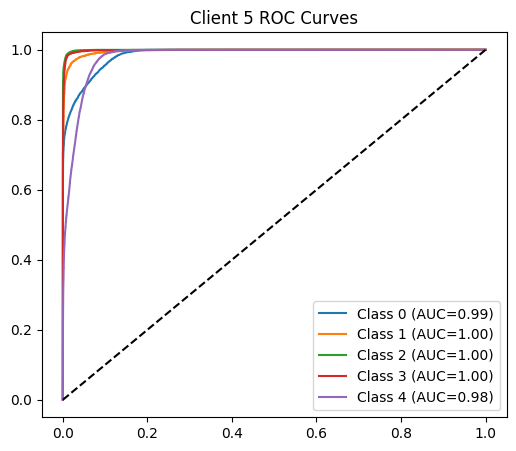


Client-wise metrics saved to: /kaggle/working/federated_results_GCN_fedfrox


In [5]:
# ============================================================
# Federated GCN for UAV Intrusion Detection (FedProx)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results_GCN_fedfrox"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

MU = 0.01        # FedProx coefficient
USE_FEDPROX = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING (FEDPROX)
# ---------------------------
def local_train(model, loader, global_model=None):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()

            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)

            # -------- FedProx term --------
            if USE_FEDPROX and global_model is not None:
                prox = 0.0
                for w, w_global in zip(model.parameters(), global_model.parameters()):
                    prox += torch.norm(w - w_global) ** 2
                loss += (MU / 2) * prox
            # -----------------------------

            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    return model.state_dict(), np.mean(losses), acc

# ---------------------------
# FEDERATED AVERAGING
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING (FEDPROX)
# ---------------------------
round_losses, round_accs = [], []
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== Round {rnd} ===")
    local_states, losses, accs = [], [], []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        state, loss, acc = local_train(
            local_model,
            edge_loader(client_splits[cid]),
            global_model
        )

        local_states.append(state)
        losses.append(loss)
        accs.append(acc)

        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))
    round_losses.append(np.mean(losses))
    round_accs.append(np.mean(accs))

    print(f"Round Avg | Loss: {round_losses[-1]:.4f} | Acc: {round_accs[-1]:.4f}")

# ---------------------------
# CONVERGENCE PLOTS
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_losses, marker='o')
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("FedProx Loss Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/fedprox_loss.png")
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_accs, marker='o')
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("FedProx Accuracy Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/fedprox_accuracy.png")
plt.show()

print("\nFedProx training complete. Results saved to:", OUTPUT_DIR)




# ============================================================
# CLIENT-WISE PERFORMANCE METRICS
# ============================================================

client_summary = []

for cid in range(NUM_CLIENTS):
    print(f"\n=== Client {cid+1} Evaluation ===")

    edges = client_splits[cid]
    src = torch.tensor(edge_pairs[0, edges]).to(DEVICE)
    dst = torch.tensor(edge_pairs[1, edges]).to(DEVICE)
    true = edge_labels[edges]

    with torch.no_grad():
        out = global_model.forward_edges(X, A_sparse, src, dst)
        preds = out.argmax(1).cpu().numpy()
        probs = torch.softmax(out, 1).cpu().numpy()

    # ---- Metrics ----
    acc = accuracy_score(true, preds)

    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        true, preds, average="macro", zero_division=0
    )
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        true, preds, average="weighted", zero_division=0
    )

    mcc = matthews_corrcoef(true, preds)
    kappa = cohen_kappa_score(true, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1_m:.4f}")
    print(f"Weighted F1: {f1_w:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Kappa: {kappa:.4f}")

    # ---- Save summary ----
    client_summary.append([
        cid + 1, acc, prec_m, rec_m, f1_m, prec_w, rec_w, f1_w, mcc, kappa
    ])

    # ---- Classification report ----
    report = classification_report(true, preds, output_dict=True, zero_division=0)
    pd.DataFrame(report).transpose().to_csv(
        f"{OUTPUT_DIR}/client_{cid+1}_classification_report.csv"
    )

    # ---- Confusion Matrix ----
    cm = confusion_matrix(true, preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Client {cid+1} Confusion Matrix")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_confusion_matrix.png")
    plt.show()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
    plt.title(f"Client {cid+1} Normalized Confusion Matrix")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_confusion_matrix_norm.png")
    plt.show()

    # ---- ROC Curves (Client-wise) ----
    y_bin = label_binarize(true, classes=range(NUM_CLASSES))

    plt.figure(figsize=(6,5))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    plt.title(f"Client {cid+1} ROC Curves")
    plt.savefig(f"{OUTPUT_DIR}/client_{cid+1}_roc.png")
    plt.show()

# ---------------------------
# SAVE CLIENT SUMMARY TABLE
# ---------------------------
df_clients = pd.DataFrame(
    client_summary,
    columns=[
        "Client", "Accuracy",
        "Macro Precision", "Macro Recall", "Macro F1",
        "Weighted Precision", "Weighted Recall", "Weighted F1",
        "MCC", "Kappa"
    ]
)

df_clients.to_csv(f"{OUTPUT_DIR}/client_wise_summary_metrics.csv", index=False)

print("\nClient-wise metrics saved to:", OUTPUT_DIR)



**FedNova**


=== FedNova Round 1 ===
Client 1 | Loss: 0.5595 | Acc: 0.7884 | Steps: 192
Client 2 | Loss: 0.5605 | Acc: 0.7869 | Steps: 192
Client 3 | Loss: 0.5611 | Acc: 0.7874 | Steps: 192
Client 4 | Loss: 0.5569 | Acc: 0.7901 | Steps: 192
Client 5 | Loss: 0.5661 | Acc: 0.7824 | Steps: 192
Round Avg | Loss: 0.5608 | Acc: 0.7871

=== FedNova Round 2 ===
Client 1 | Loss: 0.5540 | Acc: 0.7931 | Steps: 192
Client 2 | Loss: 0.5591 | Acc: 0.7838 | Steps: 192
Client 3 | Loss: 0.5567 | Acc: 0.7887 | Steps: 192
Client 4 | Loss: 0.5548 | Acc: 0.7908 | Steps: 192
Client 5 | Loss: 0.5578 | Acc: 0.7838 | Steps: 192
Round Avg | Loss: 0.5565 | Acc: 0.7880

=== FedNova Round 3 ===
Client 1 | Loss: 0.5576 | Acc: 0.7910 | Steps: 192
Client 2 | Loss: 0.5517 | Acc: 0.7910 | Steps: 192
Client 3 | Loss: 0.5539 | Acc: 0.7913 | Steps: 192
Client 4 | Loss: 0.5628 | Acc: 0.7879 | Steps: 192
Client 5 | Loss: 0.5522 | Acc: 0.7926 | Steps: 192
Round Avg | Loss: 0.5556 | Acc: 0.7908

=== FedNova Round 4 ===
Client 1 | Loss: 0

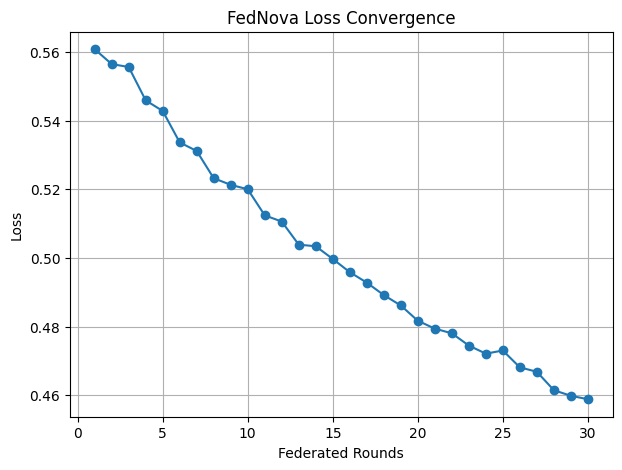

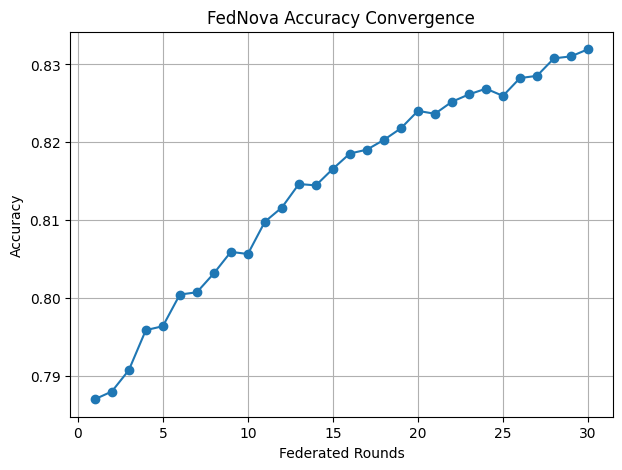


=== Global Test Metrics ===
Accuracy: 0.9210
Macro F1: 0.9230
Weighted F1: 0.9213
MCC: 0.9018
Kappa: 0.9010


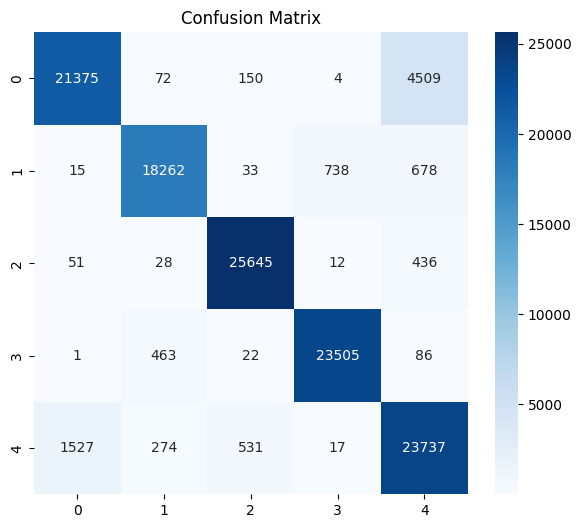

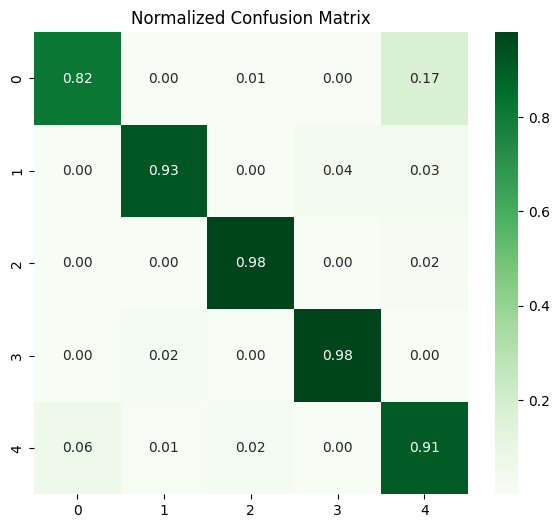

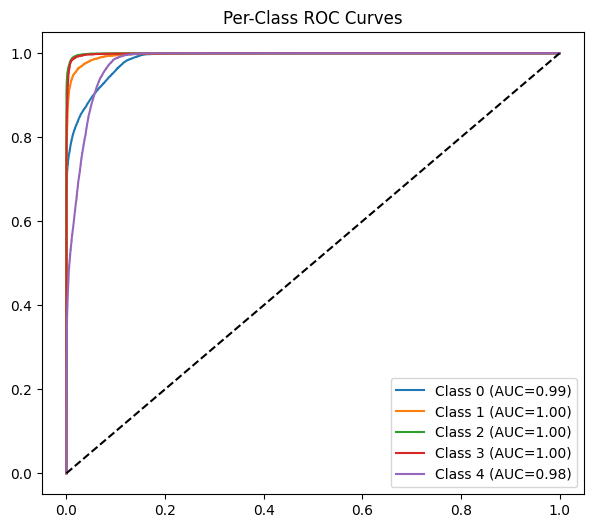


FedNova training complete.
Results saved to: /kaggle/working/federated_results_GCN_Nova


In [6]:
# ============================================================
# Federated GCN for UAV Intrusion Detection (FedNova)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/federated_results_GCN_Nova"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
K = 5
HIDDEN_DIM = 64

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

# ---------------------------
# GRAPH CONSTRUCTION
# ---------------------------
adj = kneighbors_graph(X_np, K, mode="connectivity", include_self=True)
adj = sp.coo_matrix(adj)

edge_pairs = np.vstack([adj.row, adj.col])
edge_labels = y_np[edge_pairs[0]]

indices = torch.tensor(edge_pairs, dtype=torch.long)
values = torch.tensor(adj.data, dtype=torch.float32)
A_sparse = torch.sparse_coo_tensor(indices, values, adj.shape).to(DEVICE)

# ---------------------------
# EDGE SPLITS
# ---------------------------
all_edges = np.arange(edge_pairs.shape[1])
train_edges, test_edges = train_test_split(
    all_edges, test_size=0.2, stratify=edge_labels, random_state=42
)

client_splits = np.array_split(train_edges, NUM_CLIENTS)

def edge_loader(edge_idx, shuffle=True):
    src = torch.tensor(edge_pairs[0, edge_idx])
    dst = torch.tensor(edge_pairs[1, edge_idx])
    lbl = torch.tensor(edge_labels[edge_idx])
    return DataLoader(
        TensorDataset(src, dst, lbl),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# GCN MODEL
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * 0.01)

    def forward(self, X, A):
        return torch.sparse.mm(A, X) @ self.W

class FederatedGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden)
        self.gcn2 = GCNLayer(hidden, hidden)
        self.fc1 = nn.Linear(hidden * 2, hidden)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward_edges(self, X, A, src, dst):
        h = F.relu(self.gcn1(X, A))
        h = F.relu(self.gcn2(h, A))
        e = torch.cat([h[src], h[dst]], dim=1)
        return self.fc2(F.relu(self.fc1(e)))

# ---------------------------
# LOCAL TRAINING (FEDNOVA)
# ---------------------------
def local_train_fednova(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds_all, labels_all = [], [], []
    local_steps = 0

    for _ in range(LOCAL_EPOCHS):
        for src, dst, lbl in loader:
            src, dst, lbl = src.to(DEVICE), dst.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()

            out = model.forward_edges(X, A_sparse, src, dst)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

            local_steps += 1
            losses.append(loss.item())
            preds_all.extend(out.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    return model.state_dict(), np.mean(losses), acc, local_steps

# ---------------------------
# FEDNOVA AGGREGATION
# ---------------------------
def fednova_aggregate(global_model, local_states, taus):
    new_state = {}
    global_state = global_model.state_dict()

    for k in global_state.keys():
        delta = torch.zeros_like(global_state[k])
        for i in range(len(local_states)):
            delta += (local_states[i][k] - global_state[k]) / taus[i]
        delta /= len(local_states)
        new_state[k] = global_state[k] + delta

    return new_state

# ---------------------------
# FEDERATED TRAINING (FEDNOVA)
# ---------------------------
round_losses, round_accs = [], []
global_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== FedNova Round {rnd} ===")

    local_states, losses, accs, taus = [], [], [], []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedGCN(X.shape[1], HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        state, loss, acc, tau = local_train_fednova(
            local_model,
            edge_loader(client_splits[cid])
        )

        local_states.append(state)
        losses.append(loss)
        accs.append(acc)
        taus.append(tau)

        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f} | Steps: {tau}")

    global_model.load_state_dict(
        fednova_aggregate(global_model, local_states, taus)
    )

    round_losses.append(np.mean(losses))
    round_accs.append(np.mean(accs))

    print(f"Round Avg | Loss: {round_losses[-1]:.4f} | Acc: {round_accs[-1]:.4f}")

# ---------------------------
# CONVERGENCE PLOTS
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_losses, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Loss")
plt.title("FedNova Loss Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/fednova_loss.png")
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_accs, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("FedNova Accuracy Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/fednova_accuracy.png")
plt.show()

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(all_true, all_preds)

prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    all_true, all_preds, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_true, all_preds, average="weighted", zero_division=0
)

mcc = matthews_corrcoef(all_true, all_preds)
kappa = cohen_kappa_score(all_true, all_preds)

print("\n=== Global Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"Weighted F1: {f1_w:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

# Save classification report
report = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
pd.DataFrame(report).transpose().to_csv(
    f"{OUTPUT_DIR}/global_classification_report.csv"
)

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(all_true, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
plt.title("Normalized Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_normalized.png")
plt.show()

# ---------------------------
# FPR & FNR
# ---------------------------
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

df_error = pd.DataFrame({
    "FPR": FP / (FP + TN + 1e-8),
    "FNR": FN / (FN + TP + 1e-8)
})
df_error.to_csv(f"{OUTPUT_DIR}/false_rates_per_class.csv")

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(all_true, classes=range(NUM_CLASSES))
all_probs = np.array(all_probs)

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("Per-Class ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_per_class.png")
plt.show()


print("\nFedNova training complete.")
print("Results saved to:", OUTPUT_DIR)


**FL-CNN==========================================================**


=== FedAvg Round 1 ===
Client 1 | Loss: 1.5770 | Acc: 0.3467
Client 2 | Loss: 1.5777 | Acc: 0.3241
Client 3 | Loss: 1.5784 | Acc: 0.3018
Client 4 | Loss: 1.5763 | Acc: 0.3145
Client 5 | Loss: 1.5777 | Acc: 0.3448
Round Avg | Loss: 1.5774 | Acc: 0.3264

=== FedAvg Round 2 ===
Client 1 | Loss: 1.4151 | Acc: 0.5179
Client 2 | Loss: 1.4281 | Acc: 0.5198
Client 3 | Loss: 1.4213 | Acc: 0.5218
Client 4 | Loss: 1.4213 | Acc: 0.5202
Client 5 | Loss: 1.4206 | Acc: 0.5149
Round Avg | Loss: 1.4213 | Acc: 0.5189

=== FedAvg Round 3 ===
Client 1 | Loss: 1.1954 | Acc: 0.5737
Client 2 | Loss: 1.1916 | Acc: 0.5754
Client 3 | Loss: 1.1930 | Acc: 0.5781
Client 4 | Loss: 1.1924 | Acc: 0.5757
Client 5 | Loss: 1.1880 | Acc: 0.5743
Round Avg | Loss: 1.1921 | Acc: 0.5754

=== FedAvg Round 4 ===
Client 1 | Loss: 1.0131 | Acc: 0.6365
Client 2 | Loss: 1.0111 | Acc: 0.6364
Client 3 | Loss: 1.0113 | Acc: 0.6351
Client 4 | Loss: 1.0163 | Acc: 0.6315
Client 5 | Loss: 1.0090 | Acc: 0.6360
Round Avg | Loss: 1.0122 | 

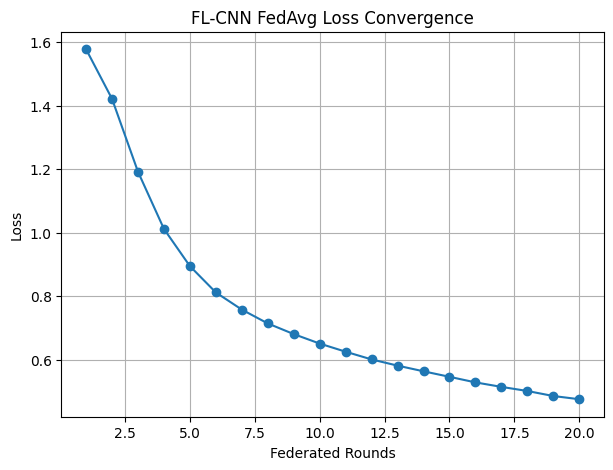

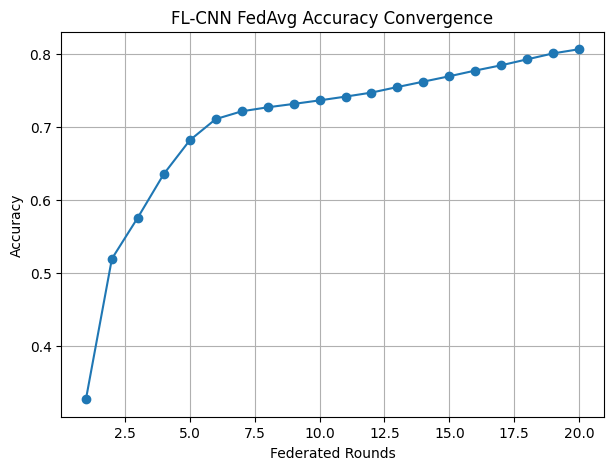


=== FL-CNN FedAvg Global Metrics ===
Accuracy: 0.8116
Macro F1: 0.8080
MCC: 0.7665
Kappa: 0.7637


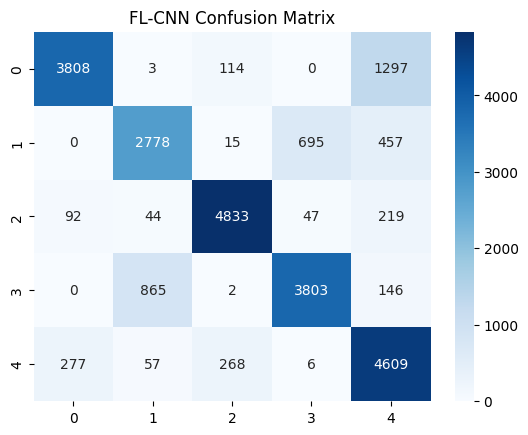


FL-CNN FedAvg experiment completed.


In [7]:
# ============================================================
# Federated CNN (FedAvg) for UAV Intrusion Detection
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/fl_cnn_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

# CNN expects (N, C, L)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y_np, dtype=torch.long)

# ---------------------------
# TRAIN / TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Client splits (non-IID optional)
client_indices = np.array_split(np.arange(len(X_train)), NUM_CLIENTS)

def client_loader(indices, shuffle=True):
    return DataLoader(
        TensorDataset(X_train[indices], y_train[indices]),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# CNN MODEL
# ---------------------------
class FederatedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds, labels = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return model.state_dict(), np.mean(losses), acc

# ---------------------------
# FEDAVG
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
round_losses, round_accs = [], []
global_model = FederatedCNN(NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== FedAvg Round {rnd} ===")

    local_states, losses, accs = [], [], []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedCNN(NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        state, loss, acc = local_train(
            local_model,
            client_loader(client_indices[cid])
        )

        local_states.append(state)
        losses.append(loss)
        accs.append(acc)

        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))
    round_losses.append(np.mean(losses))
    round_accs.append(np.mean(accs))

    print(f"Round Avg | Loss: {round_losses[-1]:.4f} | Acc: {round_accs[-1]:.4f}")

# ---------------------------
# CONVERGENCE PLOTS
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_losses, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Loss")
plt.title("FL-CNN FedAvg Loss Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/loss_convergence.png")
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_accs, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("FL-CNN FedAvg Accuracy Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/accuracy_convergence.png")
plt.show()

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
global_model.eval()
with torch.no_grad():
    out = global_model(X_test.to(DEVICE))
    preds = out.argmax(1).cpu().numpy()
    probs = torch.softmax(out, 1).cpu().numpy()

y_true = y_test.numpy()

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(y_true, preds)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_true, preds, average="macro", zero_division=0
)

mcc = matthews_corrcoef(y_true, preds)
kappa = cohen_kappa_score(y_true, preds)

print("\n=== FL-CNN FedAvg Global Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

pd.DataFrame(
    classification_report(y_true, preds, output_dict=True)
).transpose().to_csv(f"{OUTPUT_DIR}/classification_report.csv")

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("FL-CNN Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

print("\nFL-CNN FedAvg experiment completed.")


**FL-KNN=============================================================================**

Client 1 trained with 19548 samples
Client 2 trained with 19547 samples
Client 3 trained with 19547 samples
Client 4 trained with 19547 samples
Client 5 trained with 19547 samples

=== FL-KNN Global Test Metrics ===
Accuracy: 0.9127
Macro F1: 0.9152
Weighted F1: 0.9131
MCC: 0.8918
Kappa: 0.8905


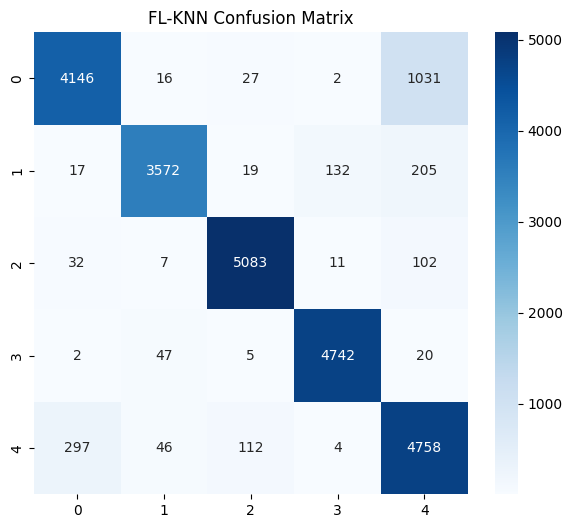

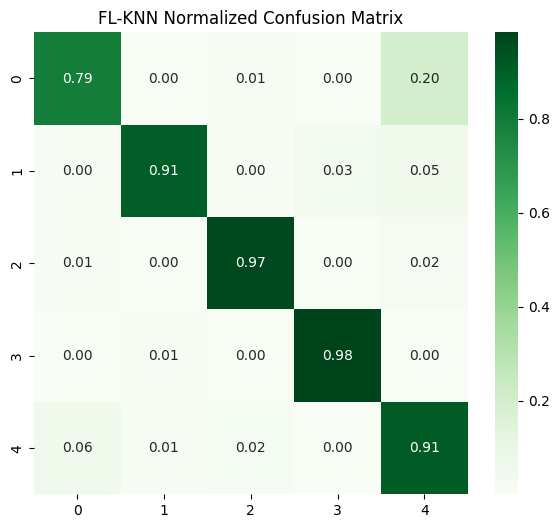

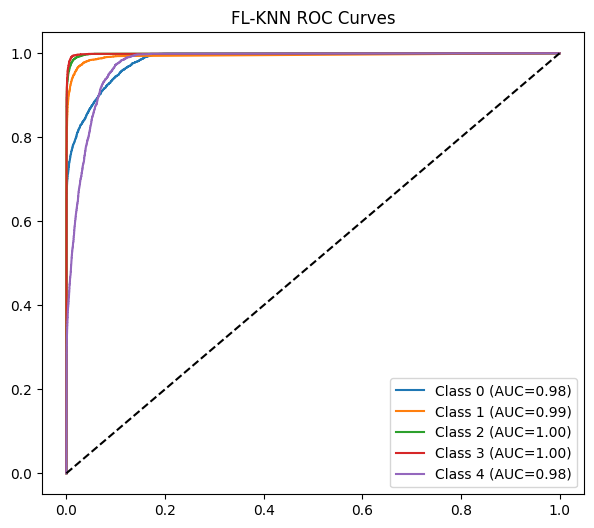


All FL-KNN results saved to: /kaggle/working/fl_knn_results


In [8]:
# ============================================================
# Federated KNN (FL-KNN) for UAV Intrusion Detection
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/fl_knn_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
K_NEIGHBORS = 5

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X = StandardScaler().fit_transform(X)

y = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y))

# ---------------------------
# TRAIN / TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# CLIENT SPLITS
# ---------------------------
client_indices = np.array_split(np.arange(len(X_train)), NUM_CLIENTS)

clients = []
for cid in range(NUM_CLIENTS):
    knn = KNeighborsClassifier(n_neighbors=K_NEIGHBORS, weights="distance")
    knn.fit(X_train[client_indices[cid]], y_train[client_indices[cid]])
    clients.append(knn)
    print(f"Client {cid+1} trained with {len(client_indices[cid])} samples")

# ---------------------------
# FEDERATED PREDICTION (VOTING)
# ---------------------------
all_client_probs = []

for cid, knn in enumerate(clients):
    probs = knn.predict_proba(X_test)
    all_client_probs.append(probs)

# Aggregate probabilities (FedAvg-style on predictions)
avg_probs = np.mean(all_client_probs, axis=0)
y_pred = np.argmax(avg_probs, axis=1)

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(y_test, y_pred)

prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print("\n=== FL-KNN Global Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"Weighted F1: {f1_w:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True)
).transpose().to_csv(f"{OUTPUT_DIR}/classification_report.csv")

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("FL-KNN Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
plt.title("FL-KNN Normalized Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_normalized.png")
plt.show()

# ---------------------------
# FPR & FNR
# ---------------------------
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

df_error = pd.DataFrame({
    "FPR": FP / (FP + TN + 1e-8),
    "FNR": FN / (FN + TP + 1e-8)
})
df_error.to_csv(f"{OUTPUT_DIR}/false_rates_per_class.csv")

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], avg_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("FL-KNN ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png")
plt.show()

print("\nAll FL-KNN results saved to:", OUTPUT_DIR)


**FL-MLP==================================================**


=== FL-MLT FedAvg Round 1 ===
Client 1 | Loss: 1.2885 | Acc: 0.5624
Client 2 | Loss: 1.2958 | Acc: 0.5597
Client 3 | Loss: 1.2853 | Acc: 0.5625
Client 4 | Loss: 1.2922 | Acc: 0.5713
Client 5 | Loss: 1.2887 | Acc: 0.5611
Round Avg | Loss: 1.2901 | Acc: 0.5634

=== FL-MLT FedAvg Round 2 ===
Client 1 | Loss: 0.8096 | Acc: 0.7053
Client 2 | Loss: 0.8252 | Acc: 0.7049
Client 3 | Loss: 0.8268 | Acc: 0.7042
Client 4 | Loss: 0.8195 | Acc: 0.7047
Client 5 | Loss: 0.8405 | Acc: 0.7011
Round Avg | Loss: 0.8243 | Acc: 0.7040

=== FL-MLT FedAvg Round 3 ===
Client 1 | Loss: 0.6733 | Acc: 0.7432
Client 2 | Loss: 0.6838 | Acc: 0.7390
Client 3 | Loss: 0.6780 | Acc: 0.7341
Client 4 | Loss: 0.6726 | Acc: 0.7402
Client 5 | Loss: 0.6780 | Acc: 0.7383
Round Avg | Loss: 0.6772 | Acc: 0.7390

=== FL-MLT FedAvg Round 4 ===
Client 1 | Loss: 0.5861 | Acc: 0.7613
Client 2 | Loss: 0.6042 | Acc: 0.7578
Client 3 | Loss: 0.6028 | Acc: 0.7549
Client 4 | Loss: 0.6019 | Acc: 0.7578
Client 5 | Loss: 0.6051 | Acc: 0.7574

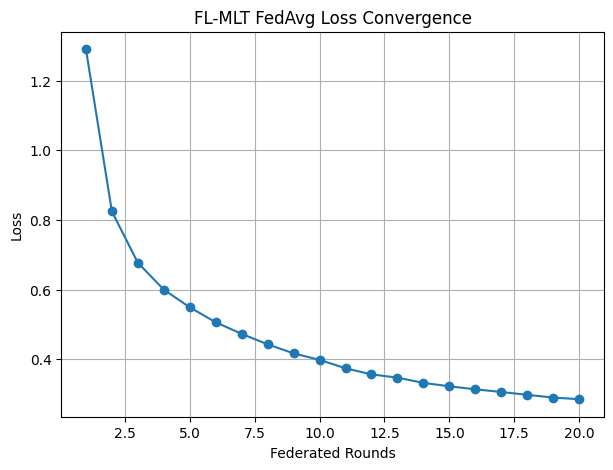

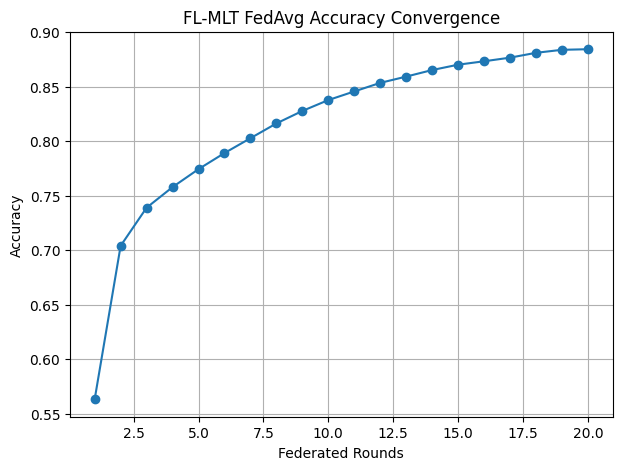


=== FL-MLT Global Test Metrics ===
Accuracy: 0.9053
Macro F1: 0.9070
Weighted F1: 0.9058
MCC: 0.8826
Kappa: 0.8812


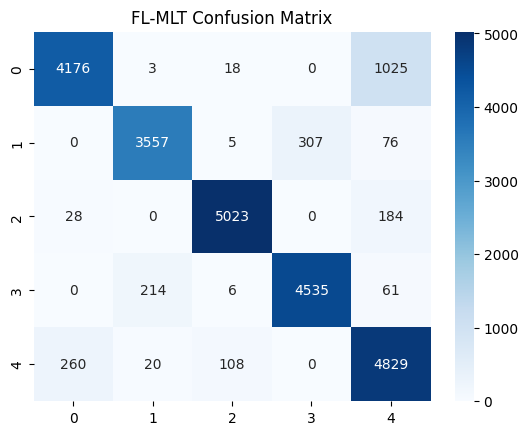

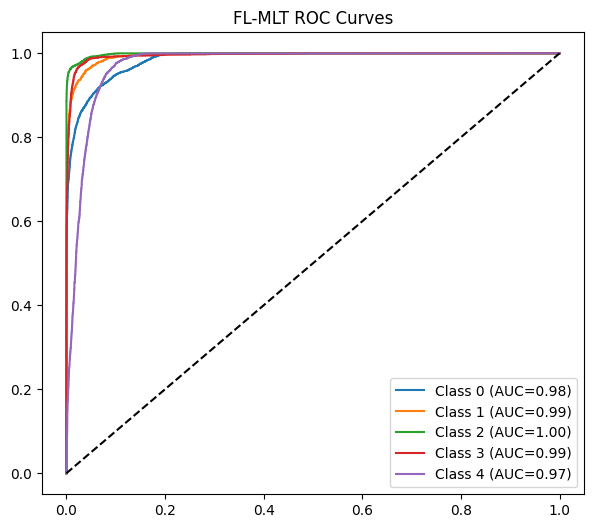


All FL-MLT results saved to: /kaggle/working/fl_mlt_results


In [9]:
# ============================================================
# Federated Multi-Layer Network (FL-MLT / MLP) with FedAvg
# UAV Intrusion Detection
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc,
    classification_report, matthews_corrcoef,
    cohen_kappa_score
)
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# CONFIGURATION
# ---------------------------
CSV_PATH = "/kaggle/input/uavids-2025/UAVIDS-2025.csv"
OUTPUT_DIR = "/kaggle/working/fl_mlt_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_CLIENTS = 5
ROUNDS = 20
LOCAL_EPOCHS = 2
BATCH_SIZE = 1024
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# LOAD & PREPROCESS DATA
# ---------------------------
df = pd.read_csv(CSV_PATH)

label_col = next(c for c in df.columns if c.lower() in ["label","class","attack","type"])
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c.lower() not in ["id","flowid","index"]]

X_np = df[num_cols[:22]].fillna(0).values.astype(np.float32)
X_np = StandardScaler().fit_transform(X_np)

y_np = LabelEncoder().fit_transform(df[label_col].astype(str))
NUM_CLASSES = len(np.unique(y_np))

X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

# ---------------------------
# TRAIN / TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Client splits
client_indices = np.array_split(np.arange(len(X_train)), NUM_CLIENTS)

def client_loader(indices, shuffle=True):
    return DataLoader(
        TensorDataset(X_train[indices], y_train[indices]),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# ---------------------------
# FL-MLT MODEL
# ---------------------------
class FederatedMLT(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ---------------------------
# LOCAL TRAINING
# ---------------------------
def local_train(model, loader):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    losses, preds, labels = [], [], []

    for _ in range(LOCAL_EPOCHS):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            losses.append(loss.item())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())

    acc = accuracy_score(labels, preds)
    return model.state_dict(), np.mean(losses), acc

# ---------------------------
# FEDAVG
# ---------------------------
def fed_avg(states):
    avg = {}
    for k in states[0]:
        avg[k] = torch.mean(torch.stack([s[k] for s in states]), dim=0)
    return avg

# ---------------------------
# FEDERATED TRAINING
# ---------------------------
round_losses, round_accs = [], []

global_model = FederatedMLT(X.shape[1], NUM_CLASSES).to(DEVICE)

for rnd in range(1, ROUNDS + 1):
    print(f"\n=== FL-MLT FedAvg Round {rnd} ===")

    local_states, losses, accs = [], [], []

    for cid in range(NUM_CLIENTS):
        local_model = FederatedMLT(X.shape[1], NUM_CLASSES).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        state, loss, acc = local_train(
            local_model,
            client_loader(client_indices[cid])
        )

        local_states.append(state)
        losses.append(loss)
        accs.append(acc)

        print(f"Client {cid+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

    global_model.load_state_dict(fed_avg(local_states))
    round_losses.append(np.mean(losses))
    round_accs.append(np.mean(accs))

    print(f"Round Avg | Loss: {round_losses[-1]:.4f} | Acc: {round_accs[-1]:.4f}")

# ---------------------------
# CONVERGENCE PLOTS
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_losses, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Loss")
plt.title("FL-MLT FedAvg Loss Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/loss_convergence.png")
plt.show()

plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), round_accs, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("FL-MLT FedAvg Accuracy Convergence")
plt.grid()
plt.savefig(f"{OUTPUT_DIR}/accuracy_convergence.png")
plt.show()

# ---------------------------
# GLOBAL TEST EVALUATION
# ---------------------------
global_model.eval()
with torch.no_grad():
    out = global_model(X_test.to(DEVICE))
    preds = out.argmax(1).cpu().numpy()
    probs = torch.softmax(out, 1).cpu().numpy()

y_true = y_test.numpy()

# ---------------------------
# GLOBAL METRICS
# ---------------------------
acc = accuracy_score(y_true, preds)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_true, preds, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, preds, average="weighted", zero_division=0
)

mcc = matthews_corrcoef(y_true, preds)
kappa = cohen_kappa_score(y_true, preds)

print("\n=== FL-MLT Global Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {f1_m:.4f}")
print(f"Weighted F1: {f1_w:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Kappa: {kappa:.4f}")

pd.DataFrame(
    classification_report(y_true, preds, output_dict=True)
).transpose().to_csv(f"{OUTPUT_DIR}/classification_report.csv")

# ---------------------------
# CONFUSION MATRIX
# ---------------------------
cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("FL-MLT Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# ---------------------------
# ROC CURVES
# ---------------------------
y_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("FL-MLT ROC Curves")
plt.savefig(f"{OUTPUT_DIR}/roc_curves.png")
plt.show()

print("\nAll FL-MLT results saved to:", OUTPUT_DIR)
